In [14]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../data2/data_tiny.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [29]:
base_neuron_count = 32

class ResidualBlock(nn.Module):
    def __init__(self, n_features):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(n_features, n_features)
        self.activation = nn.ELU()

    def forward(self, x):
        return self.activation(self.fc(x) + x)

class TabularFFNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularFFNN, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, base_neuron_count),
            nn.ELU(),
            nn.LayerNorm(base_neuron_count),
            nn.Linear(base_neuron_count, base_neuron_count * 2),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(base_neuron_count * 2, base_neuron_count * 2),
            nn.ELU(),
            nn.LayerNorm(base_neuron_count * 2),
            nn.Linear(base_neuron_count * 2, base_neuron_count // 2),
            ResidualBlock(base_neuron_count // 2),
            nn.Dropout(0.4),
            nn.Linear(base_neuron_count // 2, output_size)
        )

    def forward(self, x):
        x = x.float()
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
class TabularFFNNOLD(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNOLD, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, base_neuron_count), 
            nn.BatchNorm1d(base_neuron_count),  # Ensure the input here has 512 features
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count), # 16
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(base_neuron_count, output_size)
        )

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, base_neuron_count),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(base_neuron_count, base_neuron_count),
            nn.ReLU(),
            nn.Linear(base_neuron_count, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it

optimizer = optim.Adam(
    model.parameters(), 
    lr=7e-4,
    weight_decay=0
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=10, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {int(train_losses[-1])}, Validation Loss: {int(val_losses[-1])}, L1: {int(l1_mean_loss)}')

Epoch 1, Training Loss: 211300, Validation Loss: 237232, L1: 237232
Epoch 101, Training Loss: 191016, Validation Loss: 216251, L1: 216251
Epoch 201, Training Loss: 103119, Validation Loss: 138556, L1: 138556
Epoch 301, Training Loss: 75974, Validation Loss: 133005, L1: 133005
Epoch 401, Training Loss: 75592, Validation Loss: 132507, L1: 132507
Epoch 501, Training Loss: 75200, Validation Loss: 132394, L1: 132394
Epoch 601, Training Loss: 74814, Validation Loss: 132115, L1: 132115
Epoch 701, Training Loss: 74449, Validation Loss: 131689, L1: 131689
Epoch 801, Training Loss: 74031, Validation Loss: 131211, L1: 131211
Epoch 901, Training Loss: 73549, Validation Loss: 130659, L1: 130659
Epoch 1001, Training Loss: 72985, Validation Loss: 130012, L1: 130012
Epoch 1101, Training Loss: 72533, Validation Loss: 129465, L1: 129465
Epoch 1201, Training Loss: 72223, Validation Loss: 129109, L1: 129109
Epoch 1301, Training Loss: 71972, Validation Loss: 128660, L1: 128660
Epoch 1401, Training Loss: 71

Epoch 12001, Training Loss: 36641, Validation Loss: 66440, L1: 66440
Epoch 12101, Training Loss: 36656, Validation Loss: 66468, L1: 66468
Epoch 12201, Training Loss: 36626, Validation Loss: 66516, L1: 66516
Epoch 12301, Training Loss: 36530, Validation Loss: 66557, L1: 66557
Epoch 12401, Training Loss: 36462, Validation Loss: 66662, L1: 66662
Epoch 12501, Training Loss: 36463, Validation Loss: 66620, L1: 66620
Epoch 12601, Training Loss: 36407, Validation Loss: 66564, L1: 66564
Epoch 12701, Training Loss: 36604, Validation Loss: 66393, L1: 66393
Epoch 12801, Training Loss: 36329, Validation Loss: 66721, L1: 66721
Epoch 12901, Training Loss: 36249, Validation Loss: 66553, L1: 66553
Epoch 13001, Training Loss: 36187, Validation Loss: 66672, L1: 66672
Epoch 13101, Training Loss: 36259, Validation Loss: 66632, L1: 66632
Epoch 13201, Training Loss: 36201, Validation Loss: 66527, L1: 66527
Epoch 13301, Training Loss: 36064, Validation Loss: 66460, L1: 66460
Epoch 13401, Training Loss: 36047,

Epoch 24001, Training Loss: 31661, Validation Loss: 68299, L1: 68299
Epoch 24101, Training Loss: 31636, Validation Loss: 68408, L1: 68408
Epoch 24201, Training Loss: 31636, Validation Loss: 68197, L1: 68197
Epoch 24301, Training Loss: 31624, Validation Loss: 68089, L1: 68089
Epoch 24401, Training Loss: 31505, Validation Loss: 68219, L1: 68219
Epoch 24501, Training Loss: 31659, Validation Loss: 68298, L1: 68298
Epoch 24601, Training Loss: 31706, Validation Loss: 68116, L1: 68116
Epoch 24701, Training Loss: 31523, Validation Loss: 68101, L1: 68101
Epoch 24801, Training Loss: 31536, Validation Loss: 68077, L1: 68077
Epoch 24901, Training Loss: 31362, Validation Loss: 68413, L1: 68413
Epoch 25001, Training Loss: 31394, Validation Loss: 68259, L1: 68259
Epoch 25101, Training Loss: 31170, Validation Loss: 68314, L1: 68314
Epoch 25201, Training Loss: 31144, Validation Loss: 68372, L1: 68372
Epoch 25301, Training Loss: 31165, Validation Loss: 68772, L1: 68772
Epoch 25401, Training Loss: 31377,

Epoch 36001, Training Loss: 27264, Validation Loss: 69955, L1: 69955
Epoch 36101, Training Loss: 27297, Validation Loss: 69802, L1: 69802
Epoch 36201, Training Loss: 27257, Validation Loss: 69934, L1: 69934
Epoch 36301, Training Loss: 27373, Validation Loss: 69692, L1: 69692
Epoch 36401, Training Loss: 27069, Validation Loss: 69684, L1: 69684
Epoch 36501, Training Loss: 27314, Validation Loss: 69781, L1: 69781
Epoch 36601, Training Loss: 27435, Validation Loss: 69721, L1: 69721
Epoch 36701, Training Loss: 26942, Validation Loss: 69879, L1: 69879
Epoch 36801, Training Loss: 26971, Validation Loss: 69770, L1: 69770
Epoch 36901, Training Loss: 26939, Validation Loss: 69640, L1: 69640
Epoch 37001, Training Loss: 27131, Validation Loss: 69790, L1: 69790
Epoch 37101, Training Loss: 27023, Validation Loss: 69740, L1: 69740
Epoch 37201, Training Loss: 26839, Validation Loss: 69648, L1: 69648
Epoch 37301, Training Loss: 26836, Validation Loss: 69758, L1: 69758
Epoch 37401, Training Loss: 26800,

Epoch 48001, Training Loss: 24255, Validation Loss: 69175, L1: 69175
Epoch 48101, Training Loss: 24536, Validation Loss: 69253, L1: 69253
Epoch 48201, Training Loss: 24360, Validation Loss: 69256, L1: 69256
Epoch 48301, Training Loss: 24366, Validation Loss: 69012, L1: 69012
Epoch 48401, Training Loss: 24802, Validation Loss: 68985, L1: 68985
Epoch 48501, Training Loss: 24252, Validation Loss: 69176, L1: 69176
Epoch 48601, Training Loss: 24252, Validation Loss: 68967, L1: 68967
Epoch 48701, Training Loss: 24084, Validation Loss: 69181, L1: 69181
Epoch 48801, Training Loss: 24256, Validation Loss: 69132, L1: 69132
Epoch 48901, Training Loss: 24014, Validation Loss: 69088, L1: 69088
Epoch 49001, Training Loss: 24097, Validation Loss: 69189, L1: 69189
Epoch 49101, Training Loss: 23988, Validation Loss: 69108, L1: 69108
Epoch 49201, Training Loss: 24336, Validation Loss: 69331, L1: 69331
Epoch 49301, Training Loss: 24300, Validation Loss: 69157, L1: 69157
Epoch 49401, Training Loss: 23941,

Epoch 60001, Training Loss: 21186, Validation Loss: 69939, L1: 69939
Epoch 60101, Training Loss: 21441, Validation Loss: 69849, L1: 69849
Epoch 60201, Training Loss: 21755, Validation Loss: 70054, L1: 70054
Epoch 60301, Training Loss: 21174, Validation Loss: 70217, L1: 70217
Epoch 60401, Training Loss: 21128, Validation Loss: 69901, L1: 69901
Epoch 60501, Training Loss: 21411, Validation Loss: 70087, L1: 70087
Epoch 60601, Training Loss: 21075, Validation Loss: 69996, L1: 69996
Epoch 60701, Training Loss: 21205, Validation Loss: 70185, L1: 70185
Epoch 60801, Training Loss: 21858, Validation Loss: 70110, L1: 70110
Epoch 60901, Training Loss: 21046, Validation Loss: 70247, L1: 70247
Epoch 61001, Training Loss: 20977, Validation Loss: 70087, L1: 70087
Epoch 61101, Training Loss: 20905, Validation Loss: 70223, L1: 70223
Epoch 61201, Training Loss: 21054, Validation Loss: 70141, L1: 70141
Epoch 61301, Training Loss: 20869, Validation Loss: 70329, L1: 70329
Epoch 61401, Training Loss: 21168,

Epoch 72001, Training Loss: 17627, Validation Loss: 69048, L1: 69048
Epoch 72101, Training Loss: 17992, Validation Loss: 69248, L1: 69248
Epoch 72201, Training Loss: 17677, Validation Loss: 69098, L1: 69098
Epoch 72301, Training Loss: 17875, Validation Loss: 69089, L1: 69089
Epoch 72401, Training Loss: 17538, Validation Loss: 69030, L1: 69030
Epoch 72501, Training Loss: 17428, Validation Loss: 69055, L1: 69055
Epoch 72601, Training Loss: 17798, Validation Loss: 69238, L1: 69238
Epoch 72701, Training Loss: 17621, Validation Loss: 69157, L1: 69157
Epoch 72801, Training Loss: 17802, Validation Loss: 69204, L1: 69204
Epoch 72901, Training Loss: 17813, Validation Loss: 69001, L1: 69001
Epoch 73001, Training Loss: 17606, Validation Loss: 68802, L1: 68802
Epoch 73101, Training Loss: 17379, Validation Loss: 68894, L1: 68894
Epoch 73201, Training Loss: 17258, Validation Loss: 68570, L1: 68570
Epoch 73301, Training Loss: 17709, Validation Loss: 69061, L1: 69061
Epoch 73401, Training Loss: 17188,

Epoch 84001, Training Loss: 14746, Validation Loss: 67937, L1: 67937
Epoch 84101, Training Loss: 14803, Validation Loss: 67983, L1: 67983
Epoch 84201, Training Loss: 15147, Validation Loss: 68096, L1: 68096
Epoch 84301, Training Loss: 14768, Validation Loss: 67749, L1: 67749
Epoch 84401, Training Loss: 15177, Validation Loss: 67924, L1: 67924
Epoch 84501, Training Loss: 14666, Validation Loss: 67834, L1: 67834
Epoch 84601, Training Loss: 14659, Validation Loss: 67796, L1: 67796
Epoch 84701, Training Loss: 15250, Validation Loss: 68000, L1: 68000
Epoch 84801, Training Loss: 15240, Validation Loss: 67663, L1: 67663
Epoch 84901, Training Loss: 14749, Validation Loss: 67808, L1: 67808
Epoch 85001, Training Loss: 14541, Validation Loss: 67735, L1: 67735
Epoch 85101, Training Loss: 14497, Validation Loss: 67646, L1: 67646
Epoch 85201, Training Loss: 14789, Validation Loss: 67572, L1: 67572
Epoch 85301, Training Loss: 15138, Validation Loss: 67736, L1: 67736
Epoch 85401, Training Loss: 14529,

Epoch 96001, Training Loss: 14088, Validation Loss: 67095, L1: 67095
Epoch 96101, Training Loss: 13389, Validation Loss: 66917, L1: 66917
Epoch 96201, Training Loss: 13438, Validation Loss: 67137, L1: 67137
Epoch 96301, Training Loss: 13651, Validation Loss: 67164, L1: 67164
Epoch 96401, Training Loss: 13495, Validation Loss: 67031, L1: 67031
Epoch 96501, Training Loss: 13194, Validation Loss: 66921, L1: 66921
Epoch 96601, Training Loss: 13150, Validation Loss: 67144, L1: 67144
Epoch 96701, Training Loss: 13211, Validation Loss: 66969, L1: 66969
Epoch 96801, Training Loss: 13067, Validation Loss: 66906, L1: 66906
Epoch 96901, Training Loss: 13540, Validation Loss: 67075, L1: 67075
Epoch 97001, Training Loss: 13367, Validation Loss: 67023, L1: 67023
Epoch 97101, Training Loss: 13513, Validation Loss: 66770, L1: 66770
Epoch 97201, Training Loss: 13467, Validation Loss: 67039, L1: 67039
Epoch 97301, Training Loss: 13202, Validation Loss: 66854, L1: 66854
Epoch 97401, Training Loss: 14013,

Epoch 108001, Training Loss: 11702, Validation Loss: 66532, L1: 66532
Epoch 108101, Training Loss: 11701, Validation Loss: 66600, L1: 66600
Epoch 108201, Training Loss: 11822, Validation Loss: 66807, L1: 66807
Epoch 108301, Training Loss: 11973, Validation Loss: 66658, L1: 66658
Epoch 108401, Training Loss: 11989, Validation Loss: 66714, L1: 66714
Epoch 108501, Training Loss: 11666, Validation Loss: 66700, L1: 66700
Epoch 108601, Training Loss: 11676, Validation Loss: 66636, L1: 66636
Epoch 108701, Training Loss: 11573, Validation Loss: 66802, L1: 66802
Epoch 108801, Training Loss: 12128, Validation Loss: 66745, L1: 66745
Epoch 108901, Training Loss: 11958, Validation Loss: 66897, L1: 66897
Epoch 109001, Training Loss: 11572, Validation Loss: 66760, L1: 66760
Epoch 109101, Training Loss: 11582, Validation Loss: 66684, L1: 66684
Epoch 109201, Training Loss: 11740, Validation Loss: 66721, L1: 66721
Epoch 109301, Training Loss: 11517, Validation Loss: 66733, L1: 66733
Epoch 109401, Traini

Epoch 120001, Training Loss: 10477, Validation Loss: 67115, L1: 67115
Epoch 120101, Training Loss: 10531, Validation Loss: 67049, L1: 67049
Epoch 120201, Training Loss: 10443, Validation Loss: 66948, L1: 66948
Epoch 120301, Training Loss: 10397, Validation Loss: 66997, L1: 66997
Epoch 120401, Training Loss: 10613, Validation Loss: 67040, L1: 67040
Epoch 120501, Training Loss: 10496, Validation Loss: 67184, L1: 67184
Epoch 120601, Training Loss: 11259, Validation Loss: 67177, L1: 67177
Epoch 120701, Training Loss: 10396, Validation Loss: 67029, L1: 67029
Epoch 120801, Training Loss: 10603, Validation Loss: 66978, L1: 66978
Epoch 120901, Training Loss: 10419, Validation Loss: 67241, L1: 67241
Epoch 121001, Training Loss: 11174, Validation Loss: 67332, L1: 67332
Epoch 121101, Training Loss: 11067, Validation Loss: 67129, L1: 67129
Epoch 121201, Training Loss: 10329, Validation Loss: 67017, L1: 67017
Epoch 121301, Training Loss: 10590, Validation Loss: 67043, L1: 67043
Epoch 121401, Traini

Epoch 132001, Training Loss: 9682, Validation Loss: 67445, L1: 67445
Epoch 132101, Training Loss: 9935, Validation Loss: 67353, L1: 67353
Epoch 132201, Training Loss: 9852, Validation Loss: 67381, L1: 67381
Epoch 132301, Training Loss: 9740, Validation Loss: 67479, L1: 67479
Epoch 132401, Training Loss: 9701, Validation Loss: 67526, L1: 67526
Epoch 132501, Training Loss: 10207, Validation Loss: 67346, L1: 67346
Epoch 132601, Training Loss: 9680, Validation Loss: 67344, L1: 67344
Epoch 132701, Training Loss: 9770, Validation Loss: 67170, L1: 67170
Epoch 132801, Training Loss: 10993, Validation Loss: 67150, L1: 67150
Epoch 132901, Training Loss: 10037, Validation Loss: 67364, L1: 67364
Epoch 133001, Training Loss: 9836, Validation Loss: 67372, L1: 67372
Epoch 133101, Training Loss: 9515, Validation Loss: 67278, L1: 67278
Epoch 133201, Training Loss: 9788, Validation Loss: 67581, L1: 67581
Epoch 133301, Training Loss: 9462, Validation Loss: 67180, L1: 67180
Epoch 133401, Training Loss: 99

Epoch 144001, Training Loss: 8890, Validation Loss: 67446, L1: 67446
Epoch 144101, Training Loss: 9516, Validation Loss: 67223, L1: 67223
Epoch 144201, Training Loss: 8789, Validation Loss: 67270, L1: 67270
Epoch 144301, Training Loss: 9345, Validation Loss: 67351, L1: 67351
Epoch 144401, Training Loss: 9229, Validation Loss: 67256, L1: 67256
Epoch 144501, Training Loss: 8677, Validation Loss: 67104, L1: 67104
Epoch 144601, Training Loss: 8849, Validation Loss: 67412, L1: 67412
Epoch 144701, Training Loss: 8797, Validation Loss: 67298, L1: 67298
Epoch 144801, Training Loss: 8729, Validation Loss: 67541, L1: 67541
Epoch 144901, Training Loss: 8671, Validation Loss: 67266, L1: 67266
Epoch 145001, Training Loss: 8946, Validation Loss: 67238, L1: 67238
Epoch 145101, Training Loss: 9740, Validation Loss: 67190, L1: 67190
Epoch 145201, Training Loss: 8820, Validation Loss: 67130, L1: 67130
Epoch 145301, Training Loss: 9201, Validation Loss: 67187, L1: 67187
Epoch 145401, Training Loss: 8688,

Epoch 156001, Training Loss: 8414, Validation Loss: 67250, L1: 67250
Epoch 156101, Training Loss: 8637, Validation Loss: 66973, L1: 66973
Epoch 156201, Training Loss: 8071, Validation Loss: 67168, L1: 67168
Epoch 156301, Training Loss: 8596, Validation Loss: 67130, L1: 67130
Epoch 156401, Training Loss: 9502, Validation Loss: 67194, L1: 67194
Epoch 156501, Training Loss: 8230, Validation Loss: 66847, L1: 66847
Epoch 156601, Training Loss: 8254, Validation Loss: 66966, L1: 66966
Epoch 156701, Training Loss: 8113, Validation Loss: 67086, L1: 67086
Epoch 156801, Training Loss: 8265, Validation Loss: 67266, L1: 67266
Epoch 156901, Training Loss: 8166, Validation Loss: 67176, L1: 67176
Epoch 157001, Training Loss: 8486, Validation Loss: 67130, L1: 67130
Epoch 157101, Training Loss: 8499, Validation Loss: 67145, L1: 67145
Epoch 157201, Training Loss: 8074, Validation Loss: 67318, L1: 67318
Epoch 157301, Training Loss: 8203, Validation Loss: 67181, L1: 67181
Epoch 157401, Training Loss: 8206,

Epoch 168001, Training Loss: 7446, Validation Loss: 67161, L1: 67161
Epoch 168101, Training Loss: 8494, Validation Loss: 67258, L1: 67258
Epoch 168201, Training Loss: 8090, Validation Loss: 67008, L1: 67008
Epoch 168301, Training Loss: 7707, Validation Loss: 67020, L1: 67020
Epoch 168401, Training Loss: 7552, Validation Loss: 66851, L1: 66851
Epoch 168501, Training Loss: 7482, Validation Loss: 67191, L1: 67191
Epoch 168601, Training Loss: 8597, Validation Loss: 67342, L1: 67342
Epoch 168701, Training Loss: 7805, Validation Loss: 66669, L1: 66669
Epoch 168801, Training Loss: 8240, Validation Loss: 66860, L1: 66860
Epoch 168901, Training Loss: 7451, Validation Loss: 67069, L1: 67069
Epoch 169001, Training Loss: 7315, Validation Loss: 66993, L1: 66993
Epoch 169101, Training Loss: 7541, Validation Loss: 66961, L1: 66961
Epoch 169201, Training Loss: 7379, Validation Loss: 66959, L1: 66959
Epoch 169301, Training Loss: 7341, Validation Loss: 67155, L1: 67155
Epoch 169401, Training Loss: 8324,

Epoch 180001, Training Loss: 7364, Validation Loss: 66801, L1: 66801
Epoch 180101, Training Loss: 6876, Validation Loss: 66577, L1: 66577
Epoch 180201, Training Loss: 6828, Validation Loss: 66547, L1: 66547
Epoch 180301, Training Loss: 7270, Validation Loss: 66337, L1: 66337
Epoch 180401, Training Loss: 7255, Validation Loss: 66334, L1: 66334
Epoch 180501, Training Loss: 6765, Validation Loss: 66592, L1: 66592
Epoch 180601, Training Loss: 7221, Validation Loss: 66379, L1: 66379
Epoch 180701, Training Loss: 6894, Validation Loss: 66727, L1: 66727
Epoch 180801, Training Loss: 7076, Validation Loss: 67099, L1: 67099
Epoch 180901, Training Loss: 7905, Validation Loss: 65939, L1: 65939
Epoch 181001, Training Loss: 6844, Validation Loss: 66887, L1: 66887
Epoch 181101, Training Loss: 6829, Validation Loss: 66796, L1: 66796
Epoch 181201, Training Loss: 6842, Validation Loss: 66781, L1: 66781
Epoch 181301, Training Loss: 6740, Validation Loss: 66853, L1: 66853
Epoch 181401, Training Loss: 6820,

Epoch 192001, Training Loss: 6364, Validation Loss: 66773, L1: 66773
Epoch 192101, Training Loss: 7307, Validation Loss: 66502, L1: 66502
Epoch 192201, Training Loss: 6791, Validation Loss: 66414, L1: 66414
Epoch 192301, Training Loss: 6512, Validation Loss: 66488, L1: 66488
Epoch 192401, Training Loss: 6796, Validation Loss: 66299, L1: 66299
Epoch 192501, Training Loss: 7122, Validation Loss: 66435, L1: 66435
Epoch 192601, Training Loss: 6440, Validation Loss: 66959, L1: 66959
Epoch 192701, Training Loss: 6418, Validation Loss: 66268, L1: 66268
Epoch 192801, Training Loss: 6242, Validation Loss: 66721, L1: 66721
Epoch 192901, Training Loss: 6615, Validation Loss: 66444, L1: 66444
Epoch 193001, Training Loss: 6485, Validation Loss: 66448, L1: 66448
Epoch 193101, Training Loss: 6524, Validation Loss: 66357, L1: 66357
Epoch 193201, Training Loss: 6798, Validation Loss: 66807, L1: 66807
Epoch 193301, Training Loss: 6525, Validation Loss: 66858, L1: 66858
Epoch 193401, Training Loss: 6293,

Epoch 204001, Training Loss: 6307, Validation Loss: 66145, L1: 66145
Epoch 204101, Training Loss: 6327, Validation Loss: 66511, L1: 66511
Epoch 204201, Training Loss: 6165, Validation Loss: 67067, L1: 67067
Epoch 204301, Training Loss: 6535, Validation Loss: 66383, L1: 66383
Epoch 204401, Training Loss: 6726, Validation Loss: 66323, L1: 66323
Epoch 204501, Training Loss: 6882, Validation Loss: 66437, L1: 66437
Epoch 204601, Training Loss: 6487, Validation Loss: 66858, L1: 66858
Epoch 204701, Training Loss: 6148, Validation Loss: 66712, L1: 66712
Epoch 204801, Training Loss: 5917, Validation Loss: 66762, L1: 66762
Epoch 204901, Training Loss: 6347, Validation Loss: 66880, L1: 66880
Epoch 205001, Training Loss: 6437, Validation Loss: 66664, L1: 66664
Epoch 205101, Training Loss: 6231, Validation Loss: 66655, L1: 66655
Epoch 205201, Training Loss: 5896, Validation Loss: 66887, L1: 66887
Epoch 205301, Training Loss: 6322, Validation Loss: 66830, L1: 66830
Epoch 205401, Training Loss: 9079,

Epoch 216001, Training Loss: 5592, Validation Loss: 67146, L1: 67146
Epoch 216101, Training Loss: 6021, Validation Loss: 66371, L1: 66371
Epoch 216201, Training Loss: 5597, Validation Loss: 66851, L1: 66851
Epoch 216301, Training Loss: 6468, Validation Loss: 66475, L1: 66475
Epoch 216401, Training Loss: 5809, Validation Loss: 66761, L1: 66761
Epoch 216501, Training Loss: 6534, Validation Loss: 66514, L1: 66514
Epoch 216601, Training Loss: 5506, Validation Loss: 66736, L1: 66736
Epoch 216701, Training Loss: 5567, Validation Loss: 66868, L1: 66868
Epoch 216801, Training Loss: 6156, Validation Loss: 66892, L1: 66892
Epoch 216901, Training Loss: 5462, Validation Loss: 66679, L1: 66679
Epoch 217001, Training Loss: 6280, Validation Loss: 66989, L1: 66989
Epoch 217101, Training Loss: 7435, Validation Loss: 67401, L1: 67401
Epoch 217201, Training Loss: 5742, Validation Loss: 66455, L1: 66455
Epoch 217301, Training Loss: 6024, Validation Loss: 66433, L1: 66433
Epoch 217401, Training Loss: 5758,

Epoch 228001, Training Loss: 5377, Validation Loss: 67087, L1: 67087
Epoch 228101, Training Loss: 5165, Validation Loss: 67146, L1: 67146
Epoch 228201, Training Loss: 5965, Validation Loss: 66796, L1: 66796
Epoch 228301, Training Loss: 5636, Validation Loss: 67418, L1: 67418
Epoch 228401, Training Loss: 6187, Validation Loss: 67324, L1: 67324
Epoch 228501, Training Loss: 5468, Validation Loss: 67062, L1: 67062
Epoch 228601, Training Loss: 5091, Validation Loss: 67257, L1: 67257
Epoch 228701, Training Loss: 5077, Validation Loss: 67299, L1: 67299
Epoch 228801, Training Loss: 5022, Validation Loss: 67036, L1: 67036
Epoch 228901, Training Loss: 5246, Validation Loss: 66927, L1: 66927
Epoch 229001, Training Loss: 5430, Validation Loss: 67276, L1: 67276
Epoch 229101, Training Loss: 5798, Validation Loss: 67318, L1: 67318
Epoch 229201, Training Loss: 5096, Validation Loss: 67313, L1: 67313
Epoch 229301, Training Loss: 6069, Validation Loss: 67455, L1: 67455
Epoch 229401, Training Loss: 5213,

Epoch 240001, Training Loss: 4813, Validation Loss: 67426, L1: 67426
Epoch 240101, Training Loss: 7283, Validation Loss: 67094, L1: 67094
Epoch 240201, Training Loss: 5584, Validation Loss: 67104, L1: 67104
Epoch 240301, Training Loss: 5552, Validation Loss: 67181, L1: 67181
Epoch 240401, Training Loss: 4809, Validation Loss: 67484, L1: 67484
Epoch 240501, Training Loss: 5225, Validation Loss: 67172, L1: 67172
Epoch 240601, Training Loss: 4813, Validation Loss: 67721, L1: 67721
Epoch 240701, Training Loss: 5081, Validation Loss: 67617, L1: 67617
Epoch 240801, Training Loss: 4795, Validation Loss: 67632, L1: 67632
Epoch 240901, Training Loss: 5455, Validation Loss: 67328, L1: 67328
Epoch 241001, Training Loss: 5386, Validation Loss: 67335, L1: 67335
Epoch 241101, Training Loss: 6204, Validation Loss: 67474, L1: 67474
Epoch 241201, Training Loss: 4755, Validation Loss: 67315, L1: 67315
Epoch 241301, Training Loss: 4719, Validation Loss: 67402, L1: 67402
Epoch 241401, Training Loss: 5160,

Epoch 252001, Training Loss: 5306, Validation Loss: 67717, L1: 67717
Epoch 252101, Training Loss: 4771, Validation Loss: 67735, L1: 67735
Epoch 252201, Training Loss: 4371, Validation Loss: 67810, L1: 67810
Epoch 252301, Training Loss: 4482, Validation Loss: 67749, L1: 67749
Epoch 252401, Training Loss: 4941, Validation Loss: 68066, L1: 68066
Epoch 252501, Training Loss: 4597, Validation Loss: 67931, L1: 67931
Epoch 252601, Training Loss: 4442, Validation Loss: 67908, L1: 67908
Epoch 252701, Training Loss: 4594, Validation Loss: 67872, L1: 67872
Epoch 252801, Training Loss: 5353, Validation Loss: 67918, L1: 67918
Epoch 252901, Training Loss: 5140, Validation Loss: 67695, L1: 67695
Epoch 253001, Training Loss: 4791, Validation Loss: 67949, L1: 67949
Epoch 253101, Training Loss: 4671, Validation Loss: 67786, L1: 67786
Epoch 253201, Training Loss: 5648, Validation Loss: 67655, L1: 67655
Epoch 253301, Training Loss: 5683, Validation Loss: 67584, L1: 67584
Epoch 253401, Training Loss: 5186,

Epoch 264001, Training Loss: 4849, Validation Loss: 68383, L1: 68383
Epoch 264101, Training Loss: 5585, Validation Loss: 68120, L1: 68120
Epoch 264201, Training Loss: 6559, Validation Loss: 68506, L1: 68506
Epoch 264301, Training Loss: 4484, Validation Loss: 68277, L1: 68277
Epoch 264401, Training Loss: 4404, Validation Loss: 68241, L1: 68241
Epoch 264501, Training Loss: 4372, Validation Loss: 68266, L1: 68266
Epoch 264601, Training Loss: 5255, Validation Loss: 68240, L1: 68240
Epoch 264701, Training Loss: 4480, Validation Loss: 68124, L1: 68124
Epoch 264801, Training Loss: 4236, Validation Loss: 68226, L1: 68226
Epoch 264901, Training Loss: 4235, Validation Loss: 68325, L1: 68325
Epoch 265001, Training Loss: 4805, Validation Loss: 68190, L1: 68190
Epoch 265101, Training Loss: 4066, Validation Loss: 68386, L1: 68386
Epoch 265201, Training Loss: 5045, Validation Loss: 68561, L1: 68561
Epoch 265301, Training Loss: 4413, Validation Loss: 68305, L1: 68305
Epoch 265401, Training Loss: 4856,

Epoch 276001, Training Loss: 4500, Validation Loss: 68861, L1: 68861
Epoch 276101, Training Loss: 3854, Validation Loss: 68795, L1: 68795
Epoch 276201, Training Loss: 4021, Validation Loss: 68670, L1: 68670
Epoch 276301, Training Loss: 3897, Validation Loss: 68679, L1: 68679
Epoch 276401, Training Loss: 4339, Validation Loss: 68671, L1: 68671
Epoch 276501, Training Loss: 4526, Validation Loss: 68921, L1: 68921
Epoch 276601, Training Loss: 4354, Validation Loss: 68775, L1: 68775
Epoch 276701, Training Loss: 4302, Validation Loss: 68710, L1: 68710
Epoch 276801, Training Loss: 4322, Validation Loss: 68802, L1: 68802
Epoch 276901, Training Loss: 4195, Validation Loss: 68812, L1: 68812
Epoch 277001, Training Loss: 4258, Validation Loss: 68822, L1: 68822
Epoch 277101, Training Loss: 3724, Validation Loss: 68984, L1: 68984
Epoch 277201, Training Loss: 3803, Validation Loss: 68976, L1: 68976
Epoch 277301, Training Loss: 3744, Validation Loss: 68845, L1: 68845
Epoch 277401, Training Loss: 3828,

Epoch 288001, Training Loss: 3941, Validation Loss: 69521, L1: 69521
Epoch 288101, Training Loss: 3773, Validation Loss: 69467, L1: 69467
Epoch 288201, Training Loss: 3720, Validation Loss: 69461, L1: 69461
Epoch 288301, Training Loss: 3576, Validation Loss: 69548, L1: 69548
Epoch 288401, Training Loss: 3606, Validation Loss: 69701, L1: 69701
Epoch 288501, Training Loss: 5015, Validation Loss: 69272, L1: 69272
Epoch 288601, Training Loss: 3608, Validation Loss: 69539, L1: 69539
Epoch 288701, Training Loss: 3651, Validation Loss: 69600, L1: 69600
Epoch 288801, Training Loss: 3322, Validation Loss: 69535, L1: 69535
Epoch 288901, Training Loss: 3510, Validation Loss: 69578, L1: 69578
Epoch 289001, Training Loss: 3472, Validation Loss: 69498, L1: 69498
Epoch 289101, Training Loss: 3481, Validation Loss: 69350, L1: 69350
Epoch 289201, Training Loss: 4578, Validation Loss: 69461, L1: 69461
Epoch 289301, Training Loss: 5486, Validation Loss: 69956, L1: 69956
Epoch 289401, Training Loss: 3415,

In [58]:
from sklearn.metrics import r2_score
model.eval()
r2_score(model(X_train).detach().numpy(), y_train)

0.9833308141276423

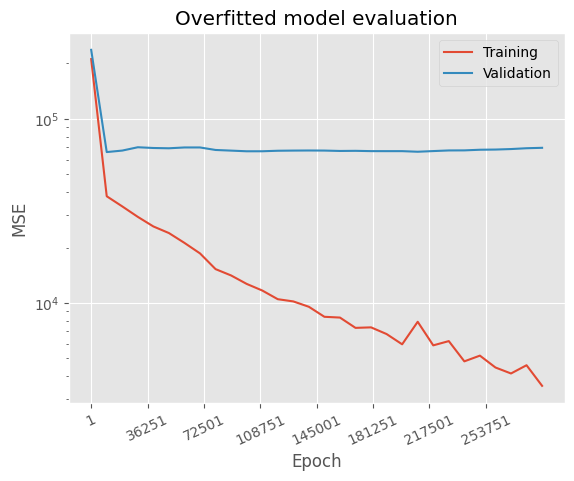

<Figure size 640x480 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.title("Overfitted model evaluation")
plt.style.use("ggplot")

# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
plt.savefig("../visualizations/overfit_model_evaluation.png", dpi=800)

In [ ]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_layer_size,
                 hidden_layer_count,
                 output_size = 1):
        
        super(TabularFFNNSimple, self).__init__()
        
        layers = [nn.Linear(input_size, hidden_layer_size), nn.ReLU()]
        
        for _ in range(hidden_layer_count - 1):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            layers.append(nn.LeakyReLU())
            
        layers.append(nn.Linear(hidden_layer_size, output_size))
        
        self.ffnn = nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x

def train(batch_size, hidden_layer_size, hidden_layer_count):

    # Split the data into features and target
    X = data.drop('price', axis=1)
    y = data['price']

    # Standardize the features
    device = torch.device("cpu")
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
    y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


    # Split the data into training and combined validation and testing sets
    X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                                test_size=0.4, random_state=42)

    # Split the combined validation and testing sets
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    # Create DataLoader for training, validation, and testing
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Check if the dimensions match the expected input size for the model
    input_size = X_train.shape[1]

    # Output
    # input_size, train_loader, test_loader

    model = TabularFFNNSimple(
        input_size = input_size,
        hidden_layer_size = hidden_layer_size,
        hidden_layer_count = hidden_layer_count,
        output_size = 1
    )
    model.to(device)

    num_epochs = 3000
    train_losses = []
    val_losses = []
    epochs_suc = [] # to have a reference to it

    optimizer = optim.Adam(
        model.parameters(), 
        lr=8e-4,
        weight_decay=5e-4
    )
    criterion = torch.nn.MSELoss()
    criterion_abs = torch.nn.L1Loss()
    criterion = criterion_abs

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.999999, 
        patience=10, 
        verbose=True
    )

    for epoch in range(num_epochs):
        # Training
        model.train()  # Set the model to training mode
        running_loss = 0.0
        l1_losses = []
        for tuple_ in train_loader:
            datas, prices = tuple_
            optimizer.zero_grad()
            outputs = model(datas)
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for tuple_ in val_loader:
                datas, prices = tuple_
                outputs = model(datas)  # Forward pass
                prices_viewed = prices.view(-1, 1).float()
                loss = criterion(outputs, prices_viewed)  # Compute loss
                val_loss += loss.item()  # Accumulate the loss
                l1_losses.append(criterion_abs(outputs, prices_viewed))

        val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
        l1_mean_loss = sum(l1_losses) / len(l1_losses)

        epochs_suc.append(epoch)
        scheduler.step(val_losses[-1])
        print(f'Epoch {epoch+1}, \
                Training Loss: {int(train_losses[-1])}, \
                Validation Loss: {int(val_losses[-1])}, L1: {int(l1_mean_loss)}')

    
    return train_losses, val_losses

In [ ]:
train(64, 32, 16)

In [ ]:
training_tuples = [
    (64, 32, 4),
    
    (64, 40, 6),
    (64, 48, 6),
    (64, 54, 6),
    (64, 64, 6),
    (64, 84, 6),
    
    (128, 64, 16),
    (128, 64, 16),
    (128, 64, 16),
    (128, 64, 16),
]

results = {}

for tuple_ in training_tuples:
    train_losses, val_losses = train(tuple_[0], tuple_[1], tuple_[2])
    results[tuple_] = (train_losses, val_losses)

In [ ]:
results_SECOND_BATCH = results

In [ ]:
training_tuples = [
    (128, 64, 2),
    (128, 64, 3),
    (128, 64, 4),
    (128, 64, 5),
    (128, 64, 6),
    (128, 64, 7),
    (128, 64, 8),
]

results = {}

for tuple_ in training_tuples:
    train_losses, val_losses = train(tuple_[0], tuple_[1], tuple_[2])
    results[tuple_] = (train_losses, val_losses)

In [ ]:
results_THIRD_BATCH = results

In [ ]:
training_tuples = [
    (128, 32, 7),
    (128, 32, 8),
    (128, 32, 8),
    (128, 16, 8),
]

results = {}

for tuple_ in training_tuples:
    train_losses, val_losses = train(tuple_[0], tuple_[1], tuple_[2])
    results[tuple_] = (train_losses, val_losses)

In [ ]:
results_FORTH_BATCH = results

In [ ]:
results_all = results_FIRST_BATCH | results_SECOND_BATCH | results_THIRD_BATCH | results_FORTH_BATCH

In [ ]:
del results_all[(64, 32, 4)]
del results_all[(64, 32, 6)]
del results_all[(64, 32, 8)]

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results' is your dictionary with training tuples as keys and (train_losses, val_losses) as values

# Define the size of the grid

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))  # Adjust the size as needed
plt.style.use('ggplot')
# Iterate over the results and create a subplot for each
for i, (params, (train_losses, val_losses)) in enumerate(results_all.items()):
    row = i // 5
    col = i % 5 
    
    ax = axs[row, col]
    
    ax.plot(train_losses, label='Training Loss', color = "b")
    ax.plot(val_losses, label='Validation Loss', color = "skyblue")
    ax.set_title(f'Layer size: {params[1]}, Layer count: {params[2]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ylim(20000, 80000)
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("../visualizations/DL_no_images_comparison.png", dpi=800)

# Show the plot
plt.show()
